In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

from datetime import datetime
from matplotlib.image import imsave

Load image

In [2]:
def load_image(img_path, max_size=512, shape=None):
    image = Image.open(img_path).convert('RGB')  

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
    transforms.Resize((size, int(1.5*size))),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image

Convert image to tensor

In [3]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [4]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1','5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content layer
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in enumerate(model.features):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [5]:
def gram_matrix(tensor):
    _, n_filters, h, w = tensor.size()
    tensor = tensor.view(n_filters, h * w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg = models.vgg19(pretrained=True)

for param in vgg.parameters():
    param.requires_grad_(False)

for i, layer in enumerate(vgg.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
    
vgg.features.to(device).eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1)

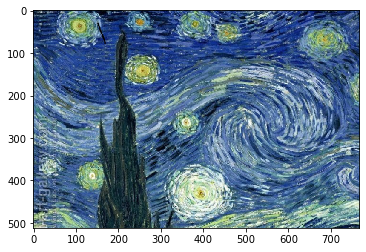

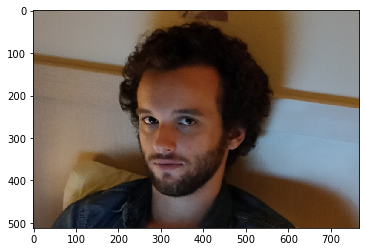

In [113]:
style = load_image("./data/gogh.jpg").to(device)
content = load_image("./data/me2.png").to(device)

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

plt.figure()
plt.imshow(im_convert(style))

plt.figure()
plt.imshow(im_convert(content))


In [114]:
def total_variation_loss(image):
    x_deltas = image[:,:,1:,:] - image[:,:,:-1,:]
    y_deltas = image[:,:,:,1:] - image[:,:,:,:-1]
    return torch.norm(x_deltas) + torch.norm(y_deltas)

In [115]:
style_grams = {
  layer: gram_matrix(style_features[layer]) for layer in style_features}

In [116]:
target = torch.randn_like(content).requires_grad_(True).to(device)
# target = content.clone().requires_grad_(True).to(device)

target.size()

torch.Size([1, 3, 512, 768])

In [117]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1e4
style_weight = 1e1
variation_weight = 1e1

In [118]:
optimizer = optim.Adam([target], lr=0.02)
losses = []

Iteration 0, Total loss: 45826.08 - (content: 0.07, style 0.26, variation 0.67)


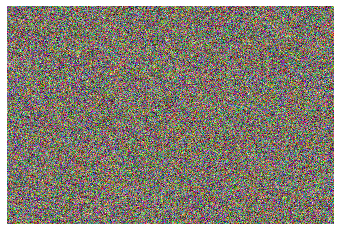

Iteration 50, Total loss: 17739.57 - (content: 0.08, style 0.18, variation 0.74)


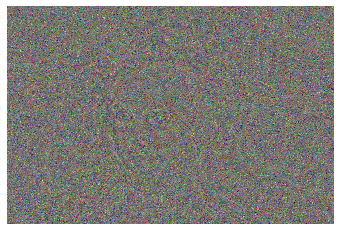

Iteration 100, Total loss: 8310.31 - (content: 0.1, style 0.3, variation 0.6)


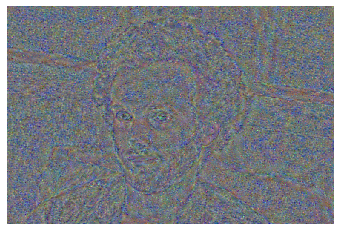

Iteration 150, Total loss: 4662.52 - (content: 0.13, style 0.4, variation 0.47)


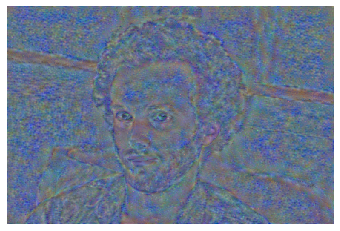

Iteration 200, Total loss: 3324.76 - (content: 0.13, style 0.5, variation 0.37)


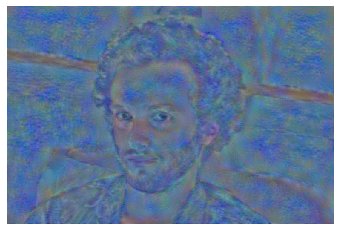

Iteration 250, Total loss: 19028.46 - (content: 0.02, style 0.94, variation 0.04)


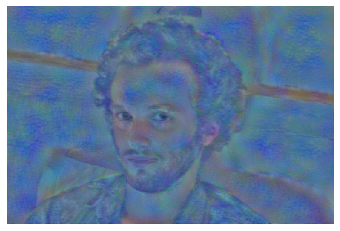

Iteration 300, Total loss: 6651.22 - (content: 0.06, style 0.14, variation 0.8)


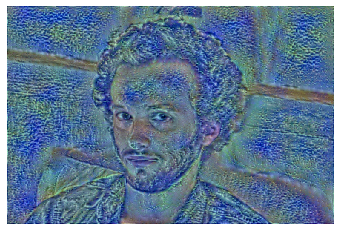

Iteration 350, Total loss: 6237.5 - (content: 0.06, style 0.12, variation 0.83)


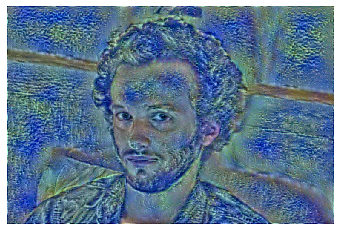

Iteration 400, Total loss: 6082.45 - (content: 0.05, style 0.11, variation 0.84)


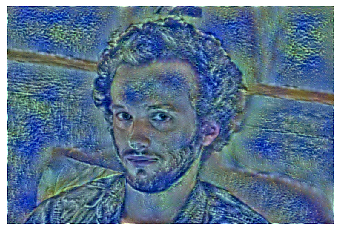

Iteration 450, Total loss: 5981.0 - (content: 0.05, style 0.1, variation 0.84)


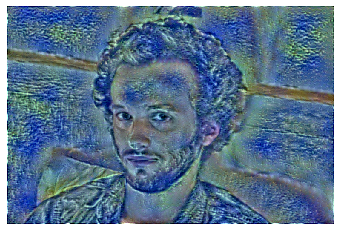

Iteration 499, Total loss: 5902.32 - (content: 0.05, style 0.1, variation 0.85)


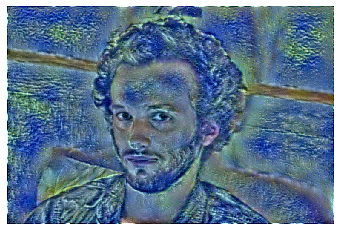

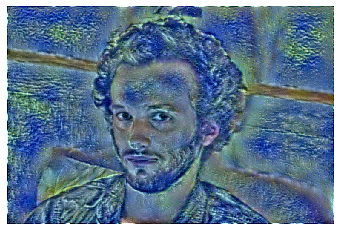

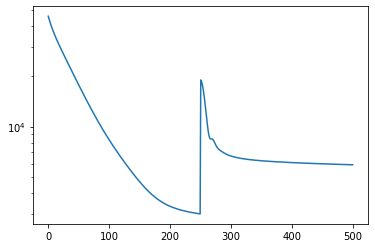

In [119]:
num_iterations = 500

frame_num = 0
for i in range(num_iterations):
    if (i == int(num_iterations/2)):
        content_weight = 1e4
        style_weight = 1e2
        variation_weight = 1e1
    
    optimizer.zero_grad()
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - \
                             content_features['conv4_2']) ** 2)
  
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean(
          (target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)

    variation_loss = total_variation_loss(target)
        
    total_loss = content_weight * content_loss + style_weight * style_loss + variation_weight * variation_loss
    losses.append(total_loss.item())
    
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    if i % 50 == 0 or i == num_iterations-1:
        total_loss_rounded = round(total_loss.item(), 2)
        content_fraction = round(content_weight*content_loss.item()/total_loss.item(), 2)
        style_fraction = round(style_weight*style_loss.item()/total_loss.item(), 2)
        variation_fraction = round(variation_weight*variation_loss.item()/total_loss.item(), 2)
        
        print('Iteration {}, Total loss: {} - (content: {}, style {}, variation {})'.format(
        i,total_loss_rounded, content_fraction, style_fraction, variation_fraction))
        
        final_img = im_convert(target)
        fig = plt.figure()
        plt.imshow(final_img)
        plt.axis('off')
        plt.pause(0.001)
        
        filename = './results/rapor/training/training{:03d}.png'.format(frame_num)
        imsave(filename, final_img)
        
        frame_num += 1

final_img = im_convert(target)
fig = plt.figure()
plt.imshow(final_img)
plt.axis('off')
plt.pause(0.001)
        
plt.figure()
plt.yscale('log')
plt.plot(losses)

final_img = im_convert(target)

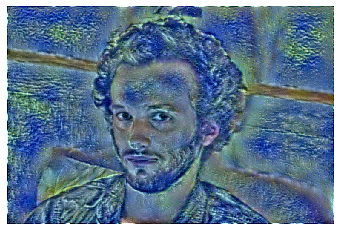

In [120]:
final_img = im_convert(target)
fig = plt.figure()
plt.imshow(final_img)
plt.axis('off')

# save image
filename = './results/gnc2.png'.format(datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))
imsave(filename, final_img)